In [1]:
using PyPlot

INFO: Loading help data...


##### Plot functions

In [2]:
function draw_arrow(i::Int64, j::Int64, action::Symbol, dim::(Int64, Int64))
    NX = dim[1]
    NY = dim[2]+1
    offset = 0.1
    if action == :north
        #plot([i-1+offset, i-0.5, i-offset, i-1+offset], [NY-j-1+offset, NY-j-offset, NY-j-1+offset, NY-j-1+offset], color="blue", lw=2)
        arrow(i-0.5, NY-j-0.9, 0, +0.3, 0, head_width=0.5, head_length=0.5, lw=3)
    elseif action == :south
        #plot([i-1+offset, i-0.5, i-offset, i-1+offset], [NY-j-offset, NY-j-1+offset, NY-j-offset, NY-j-offset], color="blue", lw=2)
        arrow(i-0.5, NY-j-0.1, 0, -0.3, 0, head_width=0.5, head_length=0.5, lw=3)
    elseif action == :east
        #plot([i-1+offset, i-1+offset, i-offset, i-1+offset], [NY-j-offset, NY-j-1+offset, NY-j-0.5, NY-j-offset], color="blue", lw=2)
        arrow(i-0.9, NY-j-0.5, +0.3, 0, head_width=0.5, head_length=0.5, lw=3)
    elseif action == :west
        #plot([i-offset, i-offset, i-1+offset, i-offset], [NY-j-offset, NY-j-1+offset, NY-j-0.5, NY-j-offset], color="blue", lw=2)
        arrow(i-0.1, NY-j-0.5, -0.3, 0, head_width=0.5, head_length=0.5, lw=3)
    end
end

function plot_data(maze::Matrix{Char}, policy::Matrix{Symbol}, V::Matrix{Float64})
    s = (size(V)[1]*1.1, size(V)[2] .* 0.5)
    figure(figsize=s)
    subplot(121)
    xticks([])
    yticks([])
    xlim([1,size(V)[1]-1])
    ylim([1,size(V)[2]-1])

    for i = 1:size(V)[1]-2
        plot([i,i],[0,size(V)[2]], color="black")
    end
    for i = 1:size(V)[2]-2
        plot([0,size(V)[1]], [i,i], color="black")
    end
    
    for i = 2:size(V)[1]-1
        for j = 2:size(V)[2]-1
            draw_arrow(j, i, policy[i, j], size(V))
            #draw_arrow(j, i, :west, size(V))
        end
    end
    subplot(122)
    colorbar(imshow(V[2:end-1,2:end-1], interpolation="none"))
    xticks([])
    yticks([])
    c_values = [v>-100?v:0 for v in V]
    clim([minimum(c_values),maximum(c_values)])
end

plot_data (generic function with 1 method)

##### Convert definition to maze representation

In [3]:
function convert_string_to_string_array(s::String)
    index = 1
    while s[index] == ' ' || s[index] == '\n'
        index = index + 1
    end
    maze = nothing
    row = []
    for i=index:length(s)
        if s[i] == '\n'
            if maze == nothing
                maze = row
            else
                maze = hcat(maze, row)
            end
            row = []
        else
            row = [row, s[i]]
        end
    end
    return maze'
end



function create_experiment_setup(definition::String)
    actions = [:north, :east, :south, :west, :none]

    maze   = convert_string_to_string_array(maze_definition)
    V      = zeros(size(maze))
    policy = reshape([actions[int64(ceil(rand() * (length(actions)-1)))] for i = 1:length(maze)], size(maze))

    for i=1:length(maze)
        if maze[i] in ['#', 'T']
            V[i] = state_reward_function[maze[i]]
            policy[i] = :none
        end
    end

    return maze, policy, V
end

create_experiment_setup (generic function with 1 method)

# Value iteration

In [18]:
function policy_iteration!(maze::Matrix{Char}, policy::Matrix{Symbol}, V::Matrix{Float64})
    for i = 2:size(maze)[1]-1
        for j = 2:size(maze)[2]-1
            if maze[i,j] == ' '
                possible_actions = []
                action_values = []
                if maze[i-1,j] != '#'
                    possible_actions = [possible_actions, :north]
                    action_values    = [action_values, V[i-1, j]]
                end
                if maze[i+1,j] != '#'
                    possible_actions = [possible_actions, :south]
                    action_values    = [action_values, V[i+1, j]]
                end

                if maze[i,j-1] != '#'
                    possible_actions = [possible_actions, :west]
                    action_values    = [action_values, V[i, j-1]]
                end
                if maze[i,j+1] != '#'
                    possible_actions = [possible_actions, :east]
                    action_values    = [action_values, V[i, j+1]]
                end
                best_action_value = maximum(action_values)
                possible_actions = possible_actions[findin(action_values,best_action_value)]
                action = possible_actions[int(ceil(rand() * length(possible_actions)))]
                policy[i,j] = action
            end
        end
    end
end

function value_iteration!(maze::Matrix{Char}, policy::Matrix{Symbol}, V::Matrix{Float64})
    new_values = copy(V)
    γ = 0.9
#    δ = 100.0
    iterations = 0
#    while δ > 0.001
        iterations = iterations + 1
        for i = 2:size(V)[1] - 1
            for j = 2:size(V)[2] - 1
                if maze[i,j] == ' '
                    values = [γ * V[i-1,j] - 1.0, γ * V[i+1,j] - 1.0, γ * V[i,j+1] - 1.0, γ * V[i,j-1] - 1.0]
                    new_values[i,j] = maximum(values)
                end
            end
        end
        δ = maximum(abs(V .- new_values))
        println("δ = $δ")
        for i=2:size(V)[1] - 1
            for j=2:size(V)[2] - 1
                V[i,j] = new_values[i,j]
            end
        end
    end
#    println("Nr. of iterations $iterations, error $δ")
    policy_iteration!(maze, policy, V)
end

LoadError: syntax: unexpected end
while loading In[18], in expression starting on line 58

δ = 1.0


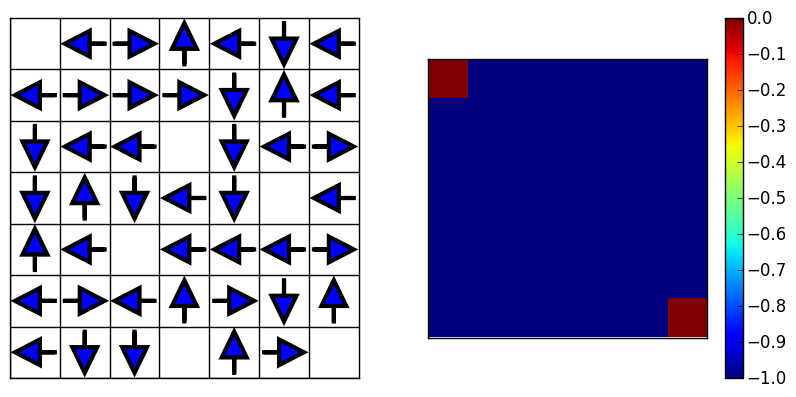

In [19]:
maze_definition = "
#########
#T      #
#       #
#   #   #
#     # #
#  #    #
#       #
#   #  T#
#########
"


state_reward_function = ['T' => 0.0, '#' => -100];


maze, policy, V = create_experiment_setup(maze_definition);
value_iteration!(maze, policy, V)
plot_data(maze, policy, V)

δ = 0.8999999999999999


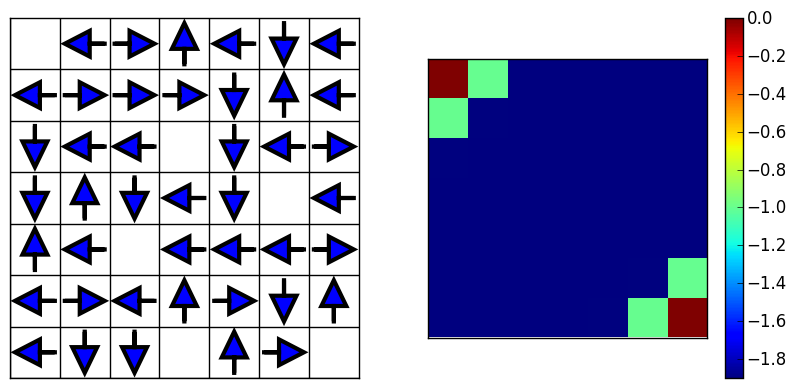

In [20]:
value_iteration!(maze, policy, V)
plot_data(maze, policy, V)

δ = 0.81


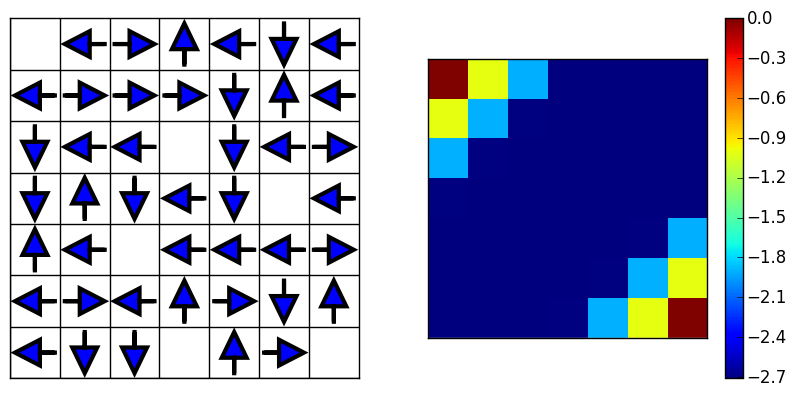

In [21]:
value_iteration!(maze, policy, V)
plot_data(maze, policy, V)

δ = 0.7290000000000001


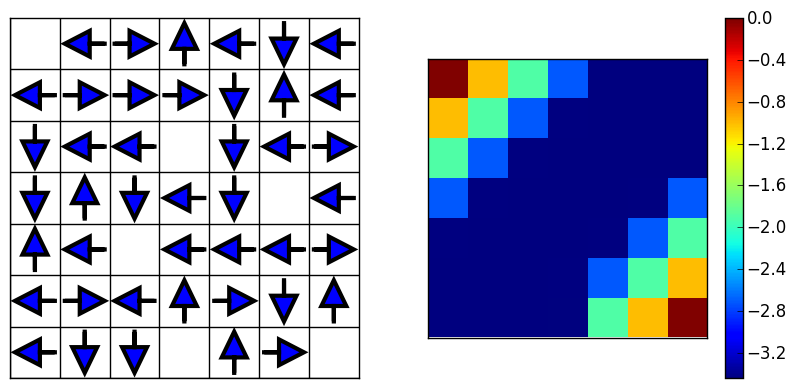

In [22]:
value_iteration!(maze, policy, V)
plot_data(maze, policy, V)

δ = 0.6561000000000003


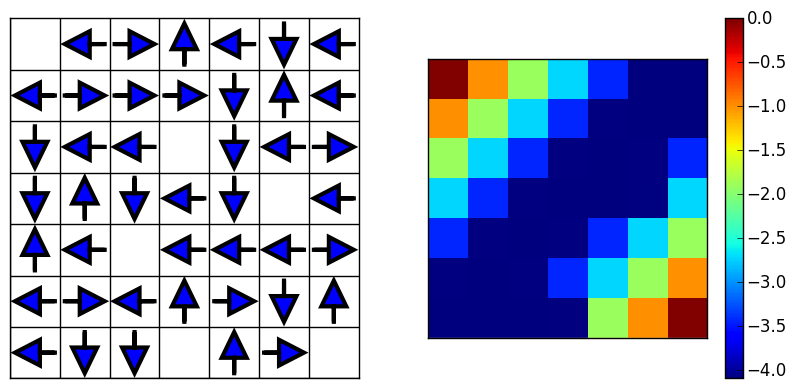

In [23]:
value_iteration!(maze, policy, V)
plot_data(maze, policy, V)

δ = 0.59049


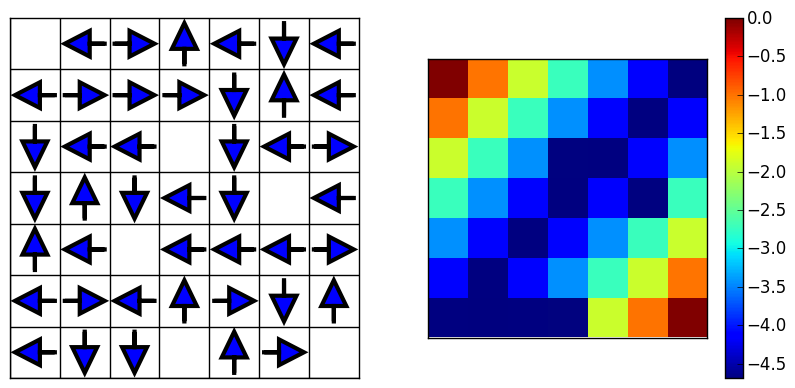

In [24]:
value_iteration!(maze, policy, V)
plot_data(maze, policy, V)

δ = 0.531441


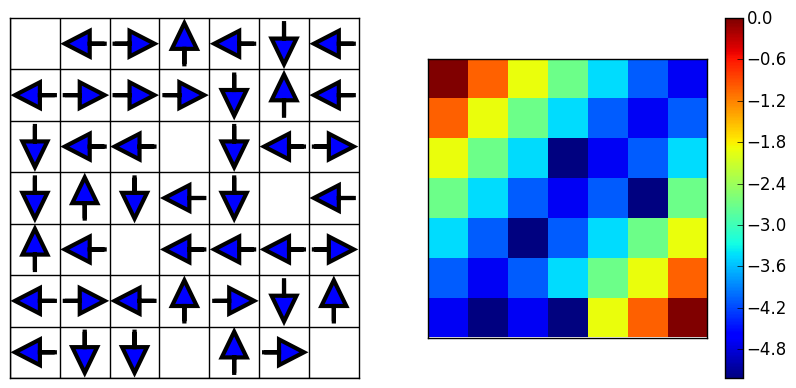

In [25]:
value_iteration!(maze, policy, V)
plot_data(maze, policy, V)

δ = 0.0


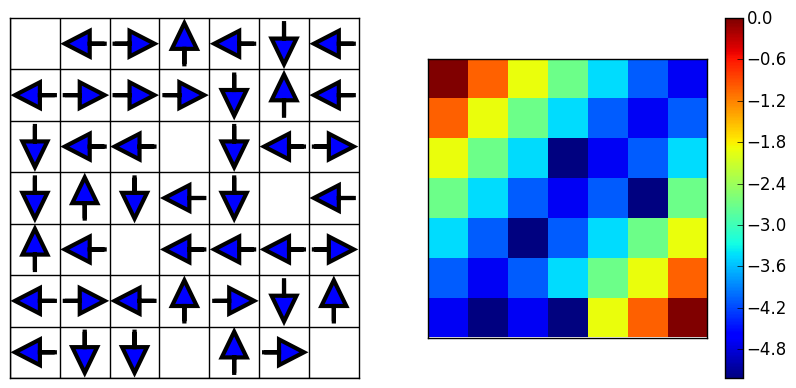

In [26]:
value_iteration!(maze, policy, V)
plot_data(maze, policy, V)